In [1]:
cd /Users/joepalmo/Desktop/cfa/SDU-preproc

/Users/joepalmo/Desktop/cfa/SDU-preproc


In [3]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from astropy.io import ascii
import os

# open source module found for converting MJD/JD to DateTimes
import jdutil as jd

# Ben's module -- THANKS BEN
import LCtools

# my preprocessing module
from preproc import *

import glob


In [4]:
# specify path to the lightcurve and spectrum
lc_path = "ZZceti/gd66cut.dat"

# object name (or abbreviation)
n = "ZZceti"

# resample length for time-sorted LC purposes
resample_len = '1d'

# Period in Days

# Raw Light Curve Exploration

In [243]:
lc = pd.read_csv(lc_path, delimiter='\s')

/Users/joepalmo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


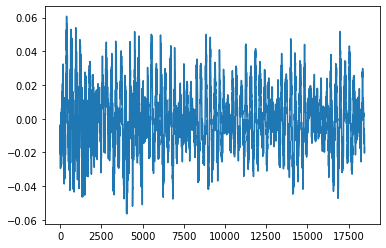

In [156]:
plt.plot(lc['Seconds'], lc['Flux'])

In [154]:
# almost 5 hours of data
17500 / 60 / 60

4.861111111111112

In [270]:
bins = np.arange(8700,11500,10)

#stack data into 2d array
arr = np.vstack((lc['Seconds'], lc['Flux'])).T

# bin by phase -> 100 points
s, edges, _ = binned_statistic(arr[:,0],arr[:,1], statistic='mean', bins=bins)
bincenters = edges[:-1]+np.diff(edges)/2

#to df - name columns
new_arr = np.vstack((bincenters, s)).T
df = pd.DataFrame(new_arr, columns = ['Seconds', 'Flux'])

In [271]:
len(df)

279

(8700.0, 11500.0)

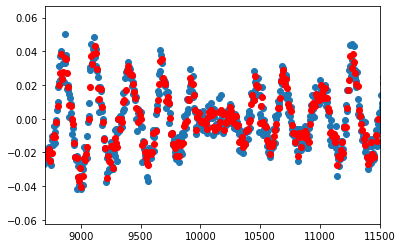

In [272]:
plt.scatter(lc['Seconds'], lc['Flux'])
plt.scatter(df['Seconds'], df['Flux'], c='r')
plt.xlim(8700,11500)

In [273]:
df['Seconds'] = df['Seconds'] - 8700

In [274]:
df

,Seconds,Flux
0,5.0,-0.022638
1,15.0,-0.020860
2,25.0,-0.020775
3,35.0,-0.017774
4,45.0,-0.025187
...,...,...
274,2745.0,-0.022405
275,2755.0,-0.022962
276,2765.0,-0.009755
277,2775.0,-0.013511


In [275]:
# duration
2785 / 60 

46.416666666666664

In [276]:
# The average data play rate determined empirically from sonoUno is about 
# 8.5 data rows played per second. Therefore:
print("Estimated video time of "+ str(len(df) / 8.5), "s")

Estimated video time of 32.8235294117647 s


In [277]:
time_preproc_lc = df

# Phased LC

In [24]:
phase_lc = pd.read_csv(lc_path, delimiter='\s', skiprows=1, names=['mjd', 'mag'])

/Users/joepalmo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [118]:
phase_lc['magerr'] = 0.0001

302 second period

In [146]:
period, phase_preproc_lc, phasefit_preproc_lc = phase_LC(phase_lc, bins=phase_bins(), rephased=False, flc=False, detrend=True, detrend_deg=3, Nmax=1, omega=303)

In [147]:
period

303

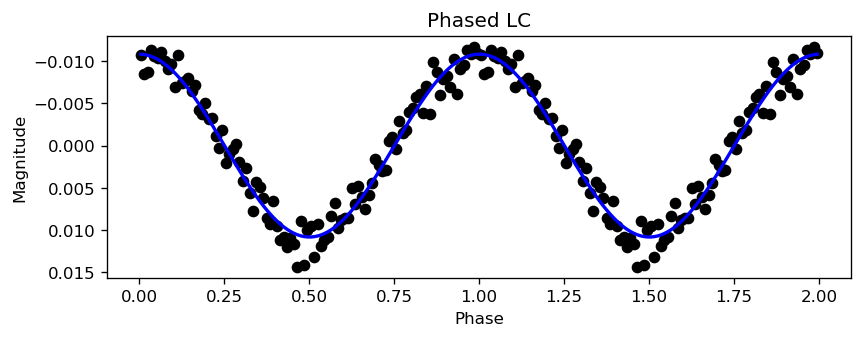

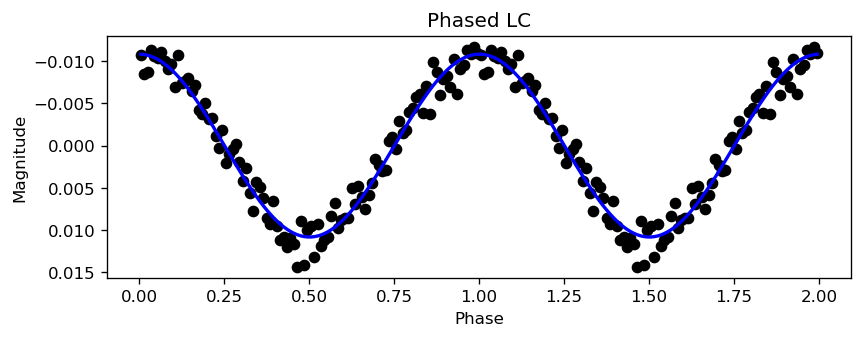

In [148]:
plot_phased(phase_preproc_lc, phasefit_preproc_lc)

# Spectra

In [287]:
spec_path = "ZZceti/gd66spec2.csv"

In [288]:
spec = pd.read_csv(spec_path, skiprows=1, names=['wavelength', 'flux'])

In [294]:
spec

,wavelength,flux
0,3652.0,1.3726
1,3654.0,1.3735
2,3656.0,1.3983
3,3658.0,1.3383
4,3660.0,1.3705
...,...,...
720,5092.0,1.9441
721,5094.0,1.9456
722,5096.0,1.9806
723,5098.0,1.9572


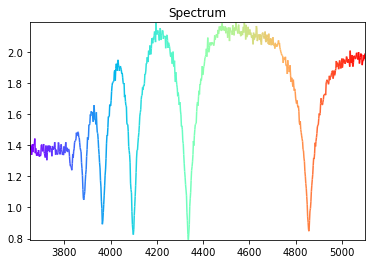

In [289]:
#raw data
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = spec['wavelength'], spec['flux']
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Spectrum')
plt.show()

In [298]:
preproc_spec = spectra_preproc(spec, bins=np.arange(3650,5100,6))

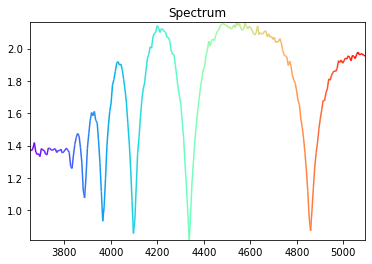

In [299]:
#preprocessed
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = preproc_spec['Wavelength'], preproc_spec['Flux']
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Spectrum')
plt.show()

In [300]:
# The average data play rate determined empirically from sonoUno is about 
# 8.5 data rows played per second. Therefore:
print("Estimated video time of "+ str(len(preproc_spec) / 8.5), "s")

Estimated video time of 28.352941176470587 s


# Save Preprocessed File

In [301]:
#create output directory
outdir = 'preproc/{}/'.format(n)
if not os.path.exists(outdir):
    os.makedirs(outdir)   

In [302]:
#save preprocessed files
time_preproc_lc.to_csv("preproc/{}/{}_LC_timesort.csv".format(n,n), index=False)
# phase_preproc_lc.to_csv("preproc/{}/{}_LC_phasesort.csv".format(n,n), index=False)
# phasefit_preproc_lc.to_csv("preproc/{}/{}_LC_phasefit.csv".format(n,n), index=False)
preproc_spec.to_csv("preproc/{}/{}_spec.csv".format(n,n), index=False)